In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('NYC_subway_traffic_2017-2021.csv')
new_df = df.copy()
new_df = new_df[['Unique ID','Datetime','Structure','Borough','Neighborhood','Entries','Exits']]
new_df['Datetime'] = pd.to_datetime(new_df['Datetime'])
new_df['Datetime_formatted'] = new_df['Datetime'].dt.strftime('%Y-%m-%d %H')
new_df['Datetime_formatted'] = pd.to_datetime(new_df['Datetime_formatted'])
new_df['Year'] = new_df['Datetime_formatted'].dt.year
new_df['Month'] = new_df['Datetime_formatted'].dt.month
new_df['Day'] = new_df['Datetime_formatted'].dt.day
new_df['Hour'] = new_df['Datetime_formatted'].dt.hour
filtered_df = new_df.copy()
filtered_df.drop(columns=['Datetime'], inplace=True)
filtered_df['Total'] = filtered_df['Entries'] + filtered_df['Exits']
filtered_df['Flow'] = filtered_df['Entries'] - filtered_df['Exits']
grouped_df = filtered_df.groupby(['Year', 'Month', 'Day','Borough']).agg({'Total': 'sum', 'Flow': 'sum'}).reset_index()

def filter_by_borough(df, borough):
    filtered_df = df[df['Borough'] == borough].copy()
    filtered_df.reset_index(drop=True, inplace=True)
    return filtered_df

In [2]:
filtered_df

,Unique ID,Structure,Borough,Neighborhood,Entries,Exits,Datetime_formatted,Year,Month,Day,Hour,Total,Flow
0,1,Subway,M,East Harlem,403.0,222.0,2017-02-04 04:00:00,2017,2,4,4,625.0,181.0
1,2,Subway,M,Upper West Side,119.0,145.0,2017-02-04 04:00:00,2017,2,4,4,264.0,-26.0
2,3,Subway,M,Upper West Side,55.0,81.0,2017-02-04 04:00:00,2017,2,4,4,136.0,-26.0
3,10,Elevated,Q,South Ozone Park/Howard Beach,156.0,30.0,2017-02-04 04:00:00,2017,2,4,4,186.0,126.0
4,11,Subway,M,East Harlem,495.0,303.0,2017-02-04 04:00:00,2017,2,4,4,798.0,192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589375,113,Subway,M,Clinton/Chelsea,1182.0,646.0,2021-08-13 20:00:00,2021,8,13,20,1828.0,536.0
4589376,114,Subway,M,Upper West Side,1274.0,445.0,2021-08-13 20:00:00,2021,8,13,20,1719.0,829.0
4589377,310,Subway,M,Financial District,433.0,549.0,2021-08-13 20:00:00,2021,8,13,20,982.0,-116.0
4589378,311,Subway,M,Financial District,491.0,844.0,2021-08-13 20:00:00,2021,8,13,20,1335.0,-353.0


In [3]:
grouped_df

,Year,Month,Day,Borough,Total,Flow
0,2017,2,4,Bk,1035099.0,200201.0
1,2017,2,4,Bx,395776.0,99302.0
2,2017,2,4,M,2616185.0,164807.0
3,2017,2,4,Q,688435.0,129037.0
4,2017,2,5,Bk,948274.0,137060.0
...,...,...,...,...,...,...
6603,2021,8,12,Q,660273.0,-5661.0
6604,2021,8,13,Bk,678924.0,14612.0
6605,2021,8,13,Bx,273219.0,29295.0
6606,2021,8,13,M,1515012.0,-235400.0


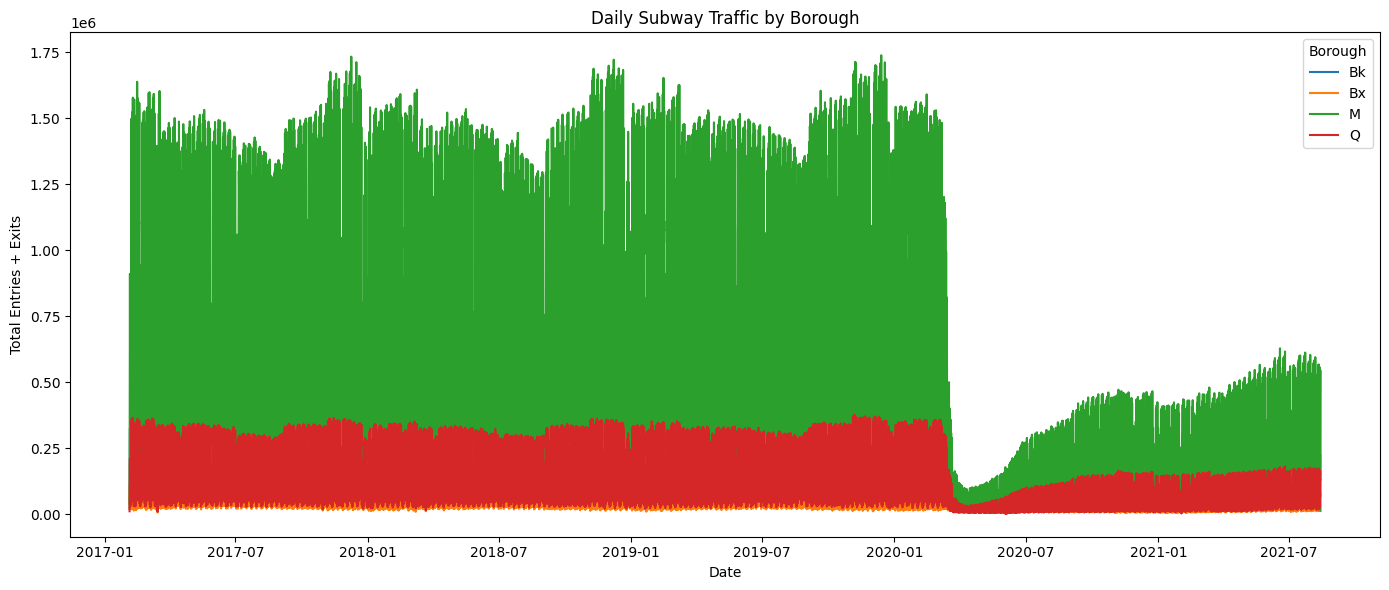

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

filtered_df['Date'] = pd.to_datetime(filtered_df['Datetime_formatted'])
filtered_df['Total'] = filtered_df['Entries'] + filtered_df['Exits']

daily_borough = filtered_df.groupby(['Date', 'Borough'])['Total'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_borough, x='Date', y='Total', hue='Borough')
plt.title('Daily Subway Traffic by Borough')
plt.ylabel('Total Entries + Exits')
plt.tight_layout()
plt.show()


In [22]:
B = filter_by_borough(grouped_df, 'Bx')
B

,Year,Month,Day,Borough,Total,Flow
0,2017,2,4,Bx,395776.0,99302.0
1,2017,2,5,Bx,338934.0,59222.0
2,2017,2,6,Bx,740837.0,204855.0
3,2017,2,7,Bx,740580.0,200566.0
4,2017,2,8,Bx,773107.0,221717.0
...,...,...,...,...,...,...
1647,2021,8,9,Bx,345198.0,7616.0
1648,2021,8,10,Bx,353305.0,3529.0
1649,2021,8,11,Bx,358520.0,7744.0
1650,2021,8,12,Bx,350678.0,5704.0


In [23]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def rolling_daily_prediction(df):
    """
    df must have columns: ['Year', 'Month', 'Day', 'Total', 'Flow']
    Train on the first week of data, then predict daily in a rolling manner.
    """
    df = df.copy()

    # Create datetime column and sort
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date').reset_index(drop=True)

    # Create numeric day index
    start_date = df['Date'].min()
    df['day_index'] = (df['Date'] - start_date).dt.days

    # Define the first week (7 days) of training data
    first_week_end = start_date + pd.Timedelta(days=6)
    train_data = df[df['Date'] <= first_week_end].copy()
    test_data = df[df['Date'] > first_week_end].copy()

    # Prepare containers for predictions and actuals
    predictions_total = []
    predictions_flow = []
    actual_total = []
    actual_flow = []
    prediction_dates = []

    # Rolling daily prediction
    for i, row in test_data.iterrows():
        X_test = [[row['day_index']]]

        # Train models
        model_total = LinearRegression().fit(train_data[['day_index']], train_data['Total'])
        model_flow = LinearRegression().fit(train_data[['day_index']], train_data['Flow'])

        # Predict
        total_pred = model_total.predict(X_test)[0]
        flow_pred = model_flow.predict(X_test)[0]

        # Store predictions
        predictions_total.append(total_pred)
        predictions_flow.append(flow_pred)
        actual_total.append(row['Total'])
        actual_flow.append(row['Flow'])
        prediction_dates.append(row['Date'])

        # Add current day to training set
        new_row = pd.DataFrame({
            'day_index': [row['day_index']],
            'Total': [row['Total']],
            'Flow': [row['Flow']]
        })
        train_data = pd.concat([train_data, new_row], ignore_index=True)

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted_Total': predictions_total,
        'Actual_Total': actual_total,
        'Predicted_Flow': predictions_flow,
        'Actual_Flow': actual_flow,
    })

    # Calculate RMSE
    total_rmse = mean_squared_error(results_df['Actual_Total'], results_df['Predicted_Total'])
    flow_rmse = mean_squared_error(results_df['Actual_Flow'], results_df['Predicted_Flow'])

    print(f"Rolling Daily Prediction Total RMSE: {total_rmse:.2f}")
    print(f"Rolling Daily Prediction Flow RMSE: {flow_rmse:.2f}")

    return results_df


/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sgurung/D

Rolling Daily Prediction Total RMSE: 27781141458.18
Rolling Daily Prediction Flow RMSE: 2769939536.97
         Date  Predicted_Total  Actual_Total  Predicted_Flow  Actual_Flow
0  2017-02-11    753969.000000      448926.0   208701.285714      94892.0
1  2017-02-12    642755.857143      310847.0   165611.500000      50701.0
2  2017-02-13    511128.916667      715964.0   118870.916667     200198.0
3  2017-02-14    586823.800000      756908.0   148071.800000     214652.0
4  2017-02-15    653606.272727      758146.0   173388.854545     206480.0
..        ...              ...           ...             ...          ...
95 2017-05-17    651690.023102      775003.0   167289.948165     204951.0
96 2017-05-18    657089.691034      766907.0   168913.498001     203493.0
97 2017-05-19    661993.318148      751631.0   170425.558252     205585.0
98 2017-05-20    666148.310623      469633.0   171966.044689      99681.0
99 2017-05-21    659521.184367      372379.0   169458.340162      69233.0

[100 rows

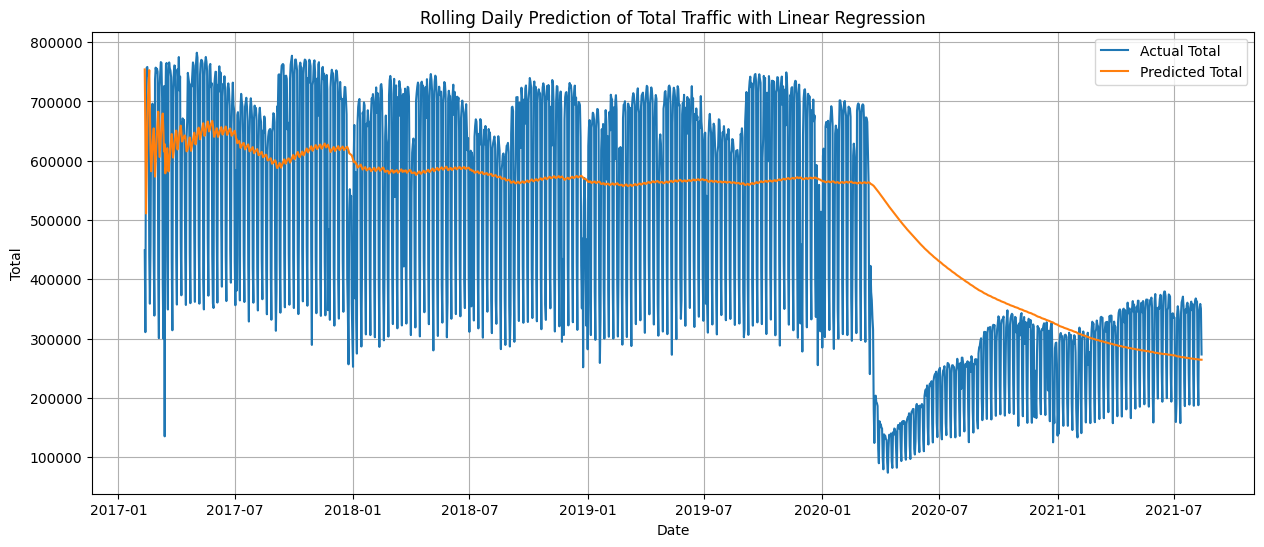

In [24]:
results2 = rolling_daily_prediction(B)
print(results2.head(100))

# Plot example

plt.figure(figsize=(15,6))
plt.plot(results2['Date'], results2['Actual_Total'], label='Actual Total')
plt.plot(results2['Date'], results2['Predicted_Total'], label='Predicted Total')
plt.title('Rolling Daily Prediction of Total Traffic with Linear Regression')
plt.xlabel('Date')
plt.ylabel('Total')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

def rolling_daily_prediction_svr(df):
    """
    df must have columns: ['Year', 'Month', 'Day', 'Total', 'Flow']
    Uses SVR instead of Linear Regression.
    Trains on the first week, then predicts daily in a rolling fashion.
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date').reset_index(drop=True)
    df['day_index'] = (df['Date'] - df['Date'].min()).dt.days

    # Train on first 7 days
    first_week_end = df['Date'].min() + pd.Timedelta(days=6)
    train_data = df[df['Date'] <= first_week_end].copy()
    test_data = df[df['Date'] > first_week_end].copy()

    # Scale features for SVR
    scaler_X = StandardScaler()
    scaler_y_total = StandardScaler()
    scaler_y_flow = StandardScaler()

    predictions_total = []
    predictions_flow = []
    actual_total = []
    actual_flow = []
    prediction_dates = []

    for i, row in test_data.iterrows():
        # Fit scalers on current training set
        X_train = train_data[['day_index']].values
        y_train_total = train_data['Total'].values.reshape(-1, 1)
        y_train_flow = train_data['Flow'].values.reshape(-1, 1)

        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_total_scaled = scaler_y_total.fit_transform(y_train_total).ravel()
        y_train_flow_scaled = scaler_y_flow.fit_transform(y_train_flow).ravel()

        # Train SVR models
        model_total = SVR(kernel='rbf', C=100, epsilon=0.1)
        model_flow = SVR(kernel='rbf', C=100, epsilon=0.1)

        model_total.fit(X_train_scaled, y_train_total_scaled)
        model_flow.fit(X_train_scaled, y_train_flow_scaled)

        # Predict
        X_test = [[row['day_index']]]
        X_test_scaled = scaler_X.transform(X_test)

        total_pred_scaled = model_total.predict(X_test_scaled)
        flow_pred_scaled = model_flow.predict(X_test_scaled)

        total_pred = scaler_y_total.inverse_transform(total_pred_scaled.reshape(-1, 1))[0][0]
        flow_pred = scaler_y_flow.inverse_transform(flow_pred_scaled.reshape(-1, 1))[0][0]

        # Store results
        predictions_total.append(total_pred)
        predictions_flow.append(flow_pred)
        actual_total.append(row['Total'])
        actual_flow.append(row['Flow'])
        prediction_dates.append(row['Date'])

        # Add row to training set
        new_row = pd.DataFrame({
            'day_index': [row['day_index']],
            'Total': [row['Total']],
            'Flow': [row['Flow']]
        })
        train_data = pd.concat([train_data, new_row], ignore_index=True)

    # Results
    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted_Total': predictions_total,
        'Actual_Total': actual_total,
        'Predicted_Flow': predictions_flow,
        'Actual_Flow': actual_flow,
    })

    # RMSE
    total_rmse = mean_squared_error(results_df['Actual_Total'], results_df['Predicted_Total'])
    flow_rmse = mean_squared_error(results_df['Actual_Flow'], results_df['Predicted_Flow'])

    print(f"SVR Daily Prediction Total RMSE: {total_rmse:.2f}")
    print(f"SVR Daily Prediction Flow RMSE: {flow_rmse:.2f}")

    return results_df


SVR Daily Prediction Total RMSE: 28347123867.34
SVR Daily Prediction Flow RMSE: 3104243288.92
         Date  Predicted_Total  Actual_Total  Predicted_Flow  Actual_Flow
0  2017-02-11     1.543008e+06      448926.0   522227.278899      94892.0
1  2017-02-12    -1.494997e+05      310847.0  -134728.664420      50701.0
2  2017-02-13     4.210541e+05      715964.0   111071.763444     200198.0
3  2017-02-14     1.340143e+06      756908.0   411439.616872     214652.0
4  2017-02-15     6.788397e+05      758146.0   192080.123404     206480.0
..        ...              ...           ...             ...          ...
95 2017-05-17     7.351406e+05      775003.0   200357.098000     204951.0
96 2017-05-18     7.617686e+05      766907.0   200486.495489     203493.0
97 2017-05-19     7.609439e+05      751631.0   200379.672554     205585.0
98 2017-05-20     7.658109e+05      469633.0   199828.855607      99681.0
99 2017-05-21     7.592889e+05      372379.0   195573.757956      69233.0

[100 rows x 5 col

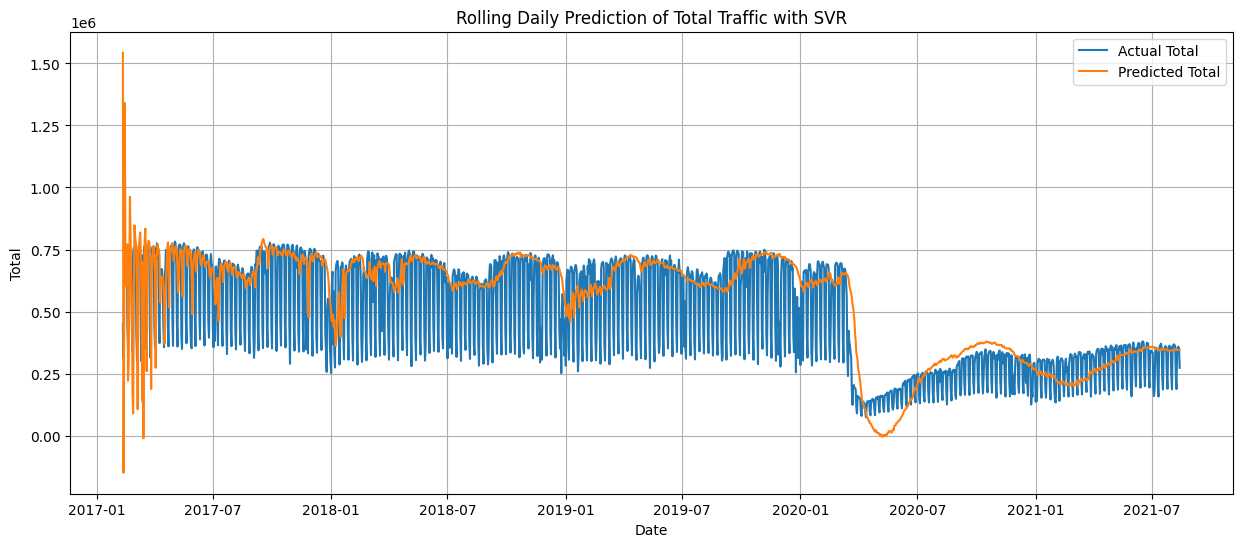

In [26]:
results1 = rolling_daily_prediction_svr(B)
print(results1.head(100))

# Plot example

plt.figure(figsize=(15,6))
plt.plot(results1['Date'], results1['Actual_Total'], label='Actual Total')
plt.plot(results1['Date'], results1['Predicted_Total'], label='Predicted Total')
plt.title('Rolling Daily Prediction of Total Traffic with SVR')
plt.xlabel('Date')
plt.ylabel('Total')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def rolling_daily_prediction_rf(df):
    """
    df must have columns: ['Year', 'Month', 'Day', 'Total', 'Flow']
    Trains on first 7 days, then predicts daily using RandomForestRegressor.
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date').reset_index(drop=True)
    df['day_index'] = (df['Date'] - df['Date'].min()).dt.days

    # Add basic temporal features
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Train on first week
    first_week_end = df['Date'].min() + pd.Timedelta(days=6)
    train_data = df[df['Date'] <= first_week_end].copy()
    test_data = df[df['Date'] > first_week_end].copy()

    # Feature columns
    feature_cols = ['day_index', 'day_of_week', 'is_weekend']

    # Storage
    predictions_total = []
    predictions_flow = []
    actual_total = []
    actual_flow = []
    prediction_dates = []

    for _, row in test_data.iterrows():
        X_train = train_data[feature_cols]
        y_train_total = train_data['Total']
        y_train_flow = train_data['Flow']

        model_total = RandomForestRegressor(n_estimators=100, random_state=42)
        model_flow = RandomForestRegressor(n_estimators=100, random_state=42)

        model_total.fit(X_train, y_train_total)
        model_flow.fit(X_train, y_train_flow)

        X_test = row[feature_cols].values.reshape(1, -1)
        total_pred = model_total.predict(X_test)[0]
        flow_pred = model_flow.predict(X_test)[0]

        predictions_total.append(total_pred)
        predictions_flow.append(flow_pred)
        actual_total.append(row['Total'])
        actual_flow.append(row['Flow'])
        prediction_dates.append(row['Date'])

        # Update training data
        new_row = pd.DataFrame({
            'day_index': [row['day_index']],
            'day_of_week': [row['day_of_week']],
            'is_weekend': [row['is_weekend']],
            'Total': [row['Total']],
            'Flow': [row['Flow']]
        })
        train_data = pd.concat([train_data, new_row], ignore_index=True)

    # Results
    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted_Total': predictions_total,
        'Actual_Total': actual_total,
        'Predicted_Flow': predictions_flow,
        'Actual_Flow': actual_flow,
    })

    # RMSE without squaring
    total_rmse = mean_squared_error(results_df['Actual_Total'], results_df['Predicted_Total'])
    flow_rmse = mean_squared_error(results_df['Actual_Flow'], results_df['Predicted_Flow'])

    print(f"Random Forest Daily Prediction Total RMSE: {total_rmse:.2f}")
    print(f"Random Forest Daily Prediction Flow RMSE: {flow_rmse:.2f}")

    return results_df


/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.wa

Random Forest Daily Prediction Total RMSE: 4017390944.35
Random Forest Daily Prediction Flow RMSE: 402337951.54
         Date  Predicted_Total  Actual_Total  Predicted_Flow  Actual_Flow
0  2017-02-11        533773.47      448926.0       136351.35      94892.0
1  2017-02-12        431932.49      310847.0        90695.41      50701.0
2  2017-02-13        705749.56      715964.0       195969.99     200198.0
3  2017-02-14        717675.86      756908.0       199550.58     214652.0
4  2017-02-15        753464.80      758146.0       214158.40     206480.0
..        ...              ...           ...             ...          ...
95 2017-05-17        769170.23      775003.0       209004.30     204951.0
96 2017-05-18        772046.54      766907.0       207421.37     203493.0
97 2017-05-19        751956.42      751631.0       202143.16     205585.0
98 2017-05-20        424301.75      469633.0        83958.51      99681.0
99 2017-05-21        352474.41      372379.0        69164.81      69233.0


/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


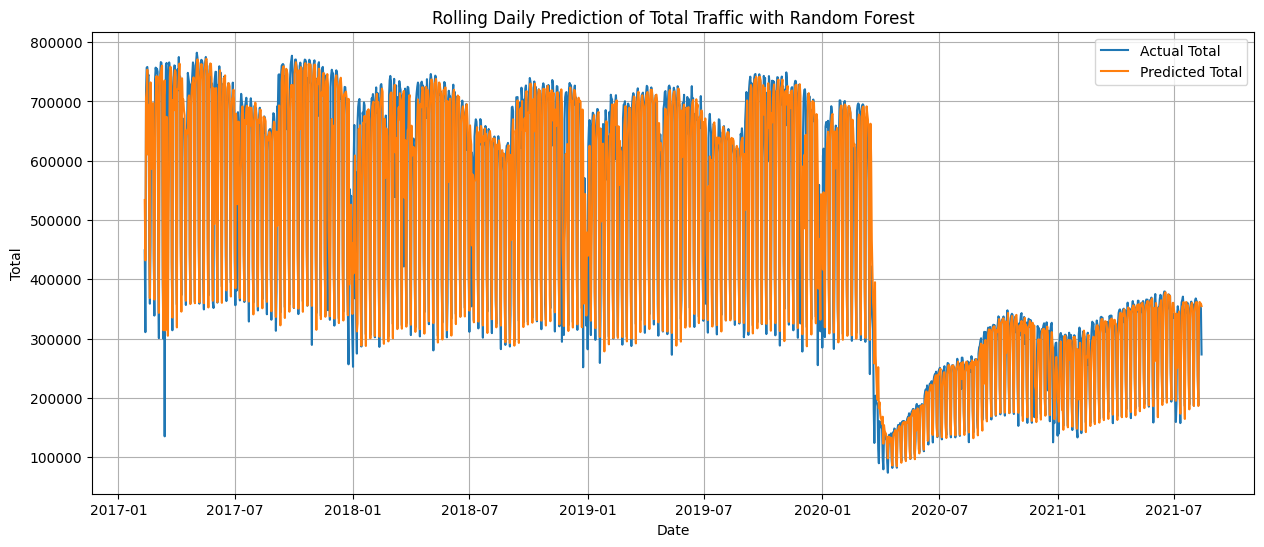

In [28]:
results = rolling_daily_prediction_rf(B)
print(results.head(100))
# Plot example
plt.figure(figsize=(15,6))
plt.plot(results['Date'], results['Actual_Total'], label='Actual Total')
plt.plot(results['Date'], results['Predicted_Total'], label='Predicted Total')
plt.title('Rolling Daily Prediction of Total Traffic with Random Forest')
plt.xlabel('Date')
plt.ylabel('Total')
plt.legend()
plt.grid(True)
plt.show()

01:58:45 - cmdstanpy - INFO - Chain [1] start processing
01:58:45 - cmdstanpy - INFO - Chain [1] done processing
01:58:45 - cmdstanpy - INFO - Chain [1] start processing
01:58:45 - cmdstanpy - INFO - Chain [1] done processing
01:58:45 - cmdstanpy - INFO - Chain [1] start processing
01:58:45 - cmdstanpy - INFO - Chain [1] done processing
01:58:45 - cmdstanpy - INFO - Chain [1] start processing
01:58:45 - cmdstanpy - INFO - Chain [1] done processing
01:58:46 - cmdstanpy - INFO - Chain [1] start processing
01:58:46 - cmdstanpy - INFO - Chain [1] done processing
01:58:46 - cmdstanpy - INFO - Chain [1] start processing
01:58:46 - cmdstanpy - INFO - Chain [1] done processing
01:58:46 - cmdstanpy - INFO - Chain [1] start processing
01:58:46 - cmdstanpy - INFO - Chain [1] done processing
01:58:46 - cmdstanpy - INFO - Chain [1] start processing
01:58:46 - cmdstanpy - INFO - Chain [1] done processing
01:58:46 - cmdstanpy - INFO - Chain [1] start processing
01:58:46 - cmdstanpy - INFO - Chain [1]

Prophet Rolling Total RMSE: 9768032142.09
         Date  Predicted_Total  Actual_Total
0  2017-02-11    753677.300538      448926.0
1  2017-02-12    643429.863990      310847.0
2  2017-02-13    511257.224653      715964.0
3  2017-02-14    587985.617982      756908.0
4  2017-02-15    653425.553101      758146.0
..        ...              ...           ...
95 2017-05-17    773888.412628      775003.0
96 2017-05-18    746753.580598      766907.0
97 2017-05-19    750459.028353      751631.0
98 2017-05-20    466038.440843      469633.0
99 2017-05-21    375277.253033      372379.0

[100 rows x 3 columns]


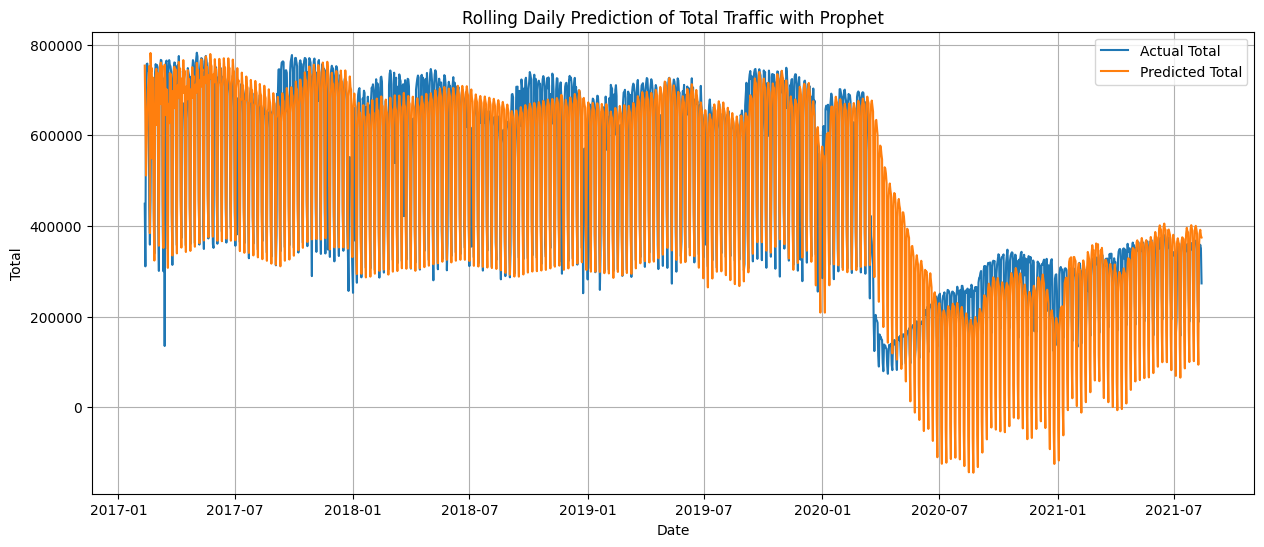

In [29]:
from prophet import Prophet
import pandas as pd
from sklearn.metrics import mean_squared_error

def rolling_daily_prediction_prophet(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date').reset_index(drop=True)

    first_week_end = df['Date'].min() + pd.Timedelta(days=6)
    train_data = df[df['Date'] <= first_week_end].copy()
    test_data = df[df['Date'] > first_week_end].copy()

    predictions_total = []
    actual_total = []
    prediction_dates = []

    for _, row in test_data.iterrows():
        prophet_df = train_data[['Date', 'Total']].rename(columns={'Date': 'ds', 'Total': 'y'})
        model = Prophet(daily_seasonality=True)
        model.fit(prophet_df)

        future = pd.DataFrame({'ds': [row['Date']]})
        forecast = model.predict(future)
        forecast_val = forecast['yhat'].values[0]

        predictions_total.append(forecast_val)
        actual_total.append(row['Total'])
        prediction_dates.append(row['Date'])

        # Update training set
        train_data = pd.concat([train_data, row.to_frame().T], ignore_index=True)

    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted_Total': predictions_total,
        'Actual_Total': actual_total
    })

    total_rmse = mean_squared_error(results_df['Actual_Total'], results_df['Predicted_Total'])
    print(f"Prophet Rolling Total RMSE: {total_rmse:.2f}")
    return results_df
results3 = rolling_daily_prediction_prophet(B)
print(results3.head(100))
# Plot example
plt.figure(figsize=(15,6))
plt.plot(results3['Date'], results3['Actual_Total'], label='Actual Total')
plt.plot(results3['Date'], results3['Predicted_Total'], label='Predicted Total')
plt.title('Rolling Daily Prediction of Total Traffic with Prophet')
plt.xlabel('Date')
plt.ylabel('Total')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

def rolling_arima_prediction(df, target='Total', p=2, d=1, q=0):
    """
    Performs rolling ARIMA predictions.
    df must have ['Year', 'Month', 'Day', target]
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date').reset_index(drop=True)

    # Split train/test
    start_date = df['Date'].min()
    first_week_end = start_date + pd.Timedelta(days=6)
    train_data = df[df['Date'] <= first_week_end].copy()
    test_data = df[df['Date'] > first_week_end].copy()

    predictions = []
    actuals = []
    prediction_dates = []

    train_series = train_data.set_index('Date')[target]

    for i, row in test_data.iterrows():
        # Fit ARIMA model
        model = ARIMA(train_series, order=(p, d, q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1)[0]

        # Store prediction
        predictions.append(forecast)
        actuals.append(row[target])
        prediction_dates.append(row['Date'])

        # Append new actual to training data
        train_series.loc[row['Date']] = row[target]

    # Results
    results_df = pd.DataFrame({
        'Date': prediction_dates,
        f'Predicted_{target}': predictions,
        f'Actual_{target}': actuals,
    })

    rmse = mean_squared_error(results_df[f'Actual_{target}'], results_df[f'Predicted_{target}'])
    print(f"Rolling ARIMA ({p},{d},{q}) {target} RMSE: {rmse:.2f}")

    return results_df


In [44]:
grouped_df

,Year,Month,Day,Borough,Total,Flow
0,2017,2,4,Bk,1035099.0,200201.0
1,2017,2,4,Bx,395776.0,99302.0
2,2017,2,4,M,2616185.0,164807.0
3,2017,2,4,Q,688435.0,129037.0
4,2017,2,5,Bk,948274.0,137060.0
...,...,...,...,...,...,...
6603,2021,8,12,Q,660273.0,-5661.0
6604,2021,8,13,Bk,678924.0,14612.0
6605,2021,8,13,Bx,273219.0,29295.0
6606,2021,8,13,M,1515012.0,-235400.0


In [45]:
grouped_df = grouped_df.dropna()
grouped_df = grouped_df[grouped_df != float('inf')]
grouped_df = grouped_df[grouped_df != -float('inf')]
